# Urgentní příjem pacientů - analýza datové sady

Jako první krok importujeme knihovnu, pomocí které chceme načíst data. Pomocí funkce .info() zkontrolujeme formu načteného datasetu (rozměry datasetu, datové typy sloupců, kompletnost dat a díky funkci .head() se můžeme podivat na první hodnoty.


In [13]:
import pandas as pd

filename = "ap2020_anonymized.xlsx"
patients_df = pd.read_excel(filename, sheet_name="IKEM")
patients_df.info()
patients_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5051 entries, 0 to 5050
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   číslo        5051 non-null   int64         
 1   ročník       5051 non-null   int64         
 2   datum a čas  5051 non-null   datetime64[ns]
 3   příjat       5051 non-null   object        
 4   důvod        5051 non-null   object        
 5   odeslán      5051 non-null   object        
 6   lékař        4967 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 276.4+ KB


,číslo,ročník,datum a čas,příjat,důvod,odeslán,lékař
0,20200001,46,2020-01-01 04:18:00,přes RZP/LSPP,bolest na hrudi,na oddělení KK,MUDr. Jan První
1,20200002,83,2020-01-01 09:09:00,z ambulance KK IKEM,jiný,domácí ošetření,MUDr. Pavel Druhý
2,20200003,72,2020-01-01 11:35:00,bez doporučení,palpitace,domácí ošetření,MUDr. Pavel Druhý
3,20200004,99,2020-01-01 14:23:00,bez doporučení,bolest na hrudi,na oddělení KK,MUDr. Pavel Druhý
4,20200005,28,2020-01-01 15:06:00,přes RZP/LSPP,jiný,na oddělení KK,MUDr. Pavel Druhý


Můžeme vidět, že data jsou poměrně kompletní, pouze ve sloupci "lékař" je několik prázdných hodnot.

Aby se mi lépe s datasetem pracovalo, přejmenuji sloupce na stringy bez mezer a diakritiky.
Dále upravým sloupec s ročníky pacientů, protože je nejednoznačný. Záznamy ve sloupci ročník v hodnotách 0-3 jsou pravděpodobně ročníky 21. století, ostatní jsou století 20.

Pro sloupec ročník může být zajímavé vyhodnotit některé základní statistické charakteristiky.

In [14]:
import numpy as np

patients_df.columns = ['id', 'year', 'datetime',
                       'accepted', 'cause', 'send_to', 'doctor']
patients_df.year = np.where(
    patients_df.year > 10, patients_df.year + 1900, patients_df.year + 2000)

patients_df.year.describe()


count    5051.000000
mean     1953.517917
std        14.061725
min      1920.000000
25%      1944.000000
50%      1950.000000
75%      1961.000000
max      2003.000000
Name: year, dtype: float64

Pak můžeme začít data vizualizovat. Používam knihovnu matplotlib a pro jednodušší a rychlejší formátování grafu v tomto případě i knihovnu seaborn. Statistické charakteristiky sloupce ročník můžeme vizualizovat pomocí boxplot.


Text(0.5, 1.0, 'Věk pacientů přijatých na urgentní oddělení')

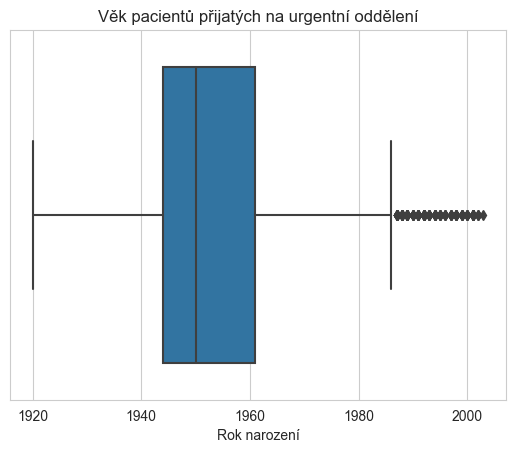

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

ax = sns.boxplot(x=patients_df.year)
ax.set(ylabel=None, xlabel="Rok narození")
ax.set_title('Věk pacientů přijatých na urgentní oddělení')

Pro plánovaní práce zdravotních sester je důležitá informace kolik pacientů mohou v jaký den očekávat.
První graf tedy ukazuje průměrnou hodnotu počtu pacientů pro každý den v týdnu.

Text(0.5, 1.0, 'Průměrný počet pacientů v roce 2020 podle dne v týdnu')

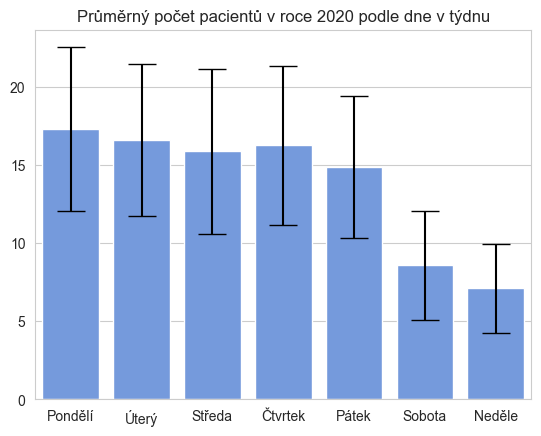

In [16]:

weekdays_df = patients_df[['id', 'datetime']]
weekdays_df = weekdays_df.groupby(pd.Grouper(key='datetime', freq='D')).count()
weekdays_df['weekday'] = weekdays_df.index.dayofweek
std_df = weekdays_df.groupby(['weekday']).std()
weekdays_df = weekdays_df.groupby(['weekday']).mean()

weekdays_df['dayname'] = ['Pondělí', 'Úterý', 'Středa',
                          'Čtvrtek', 'Pátek', 'Sobota', 'Neděle']

plt.rcParams.update({'errorbar.capsize': 10})
ax = sns.barplot(y=weekdays_df.id, x=weekdays_df.dayname,
                 color='cornflowerblue', yerr=std_df.id)
ax.set(ylabel=None, xlabel=None)
ax.set_title('Průměrný počet pacientů v roce 2020 podle dne v týdnu')


Další zajímavou informací je proměnlivost vytížení oddělení v průběhu roku. Druhý graf ukazuje počty pacientů přijatých v jednotlivých týdnech roku 2020.

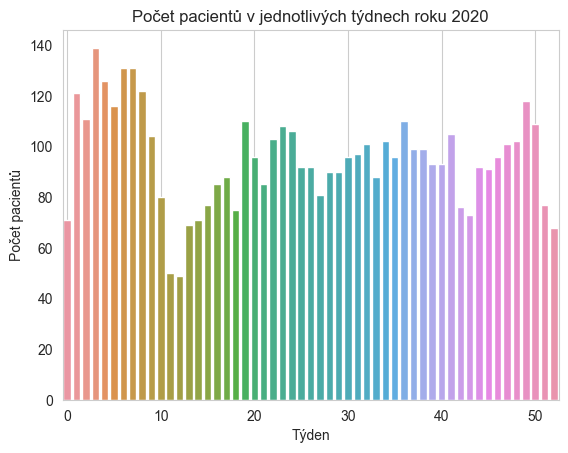

In [17]:
weeks_df = patients_df.groupby(pd.Grouper(key='datetime', freq='W')).count()

ax = sns.barplot(x=weeks_df.index, y=weeks_df['id'])
ax.set(xlabel='Týden', ylabel='Počet pacientů')
ax.set_xticks([0, 10, 20, 30, 40, 50])
ax.set_xticklabels([0, 10, 20, 30, 40, 50])
ax.set_title("Počet pacientů v jednotlivých týdnech roku 2020")
plt.grid()


Většinu lidí by asi zajímalo v jakékm věku je nejvyšší pravděpodobnost, že skončí na zkoumaném oddělení a také jakou bude mít jejich návštěva příčinu.

Text(0.5, 1.0, 'Počet a důvod návštěv dle roku narození')

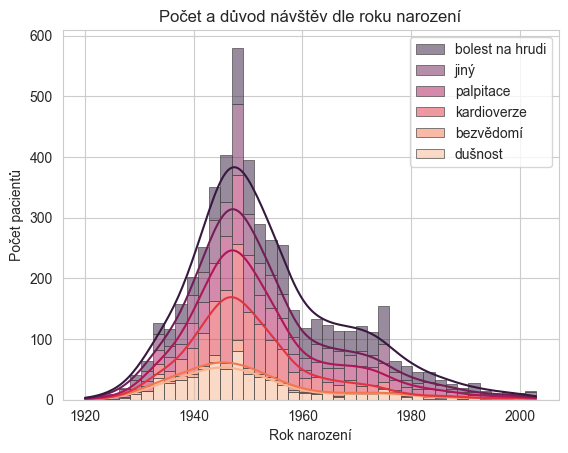

In [19]:
ax = sns.histplot(
    patients_df,
    x="year", hue="cause",
    multiple="stack",
    palette="rocket",
    edgecolor=".3",
    linewidth=.5,
    bins=40,
    kde=True
)
ax.set(xlabel='Rok narození', ylabel='Počet pacientů')
ax.legend_.set_title(None)
ax.set_title("Počet a důvod návštěv dle roku narození")


Souvislost informace odkud byli pacienti přijati a jaké měli potíže můžeme vidět na následujícím grafu spolu s množstvím případů obtíží.

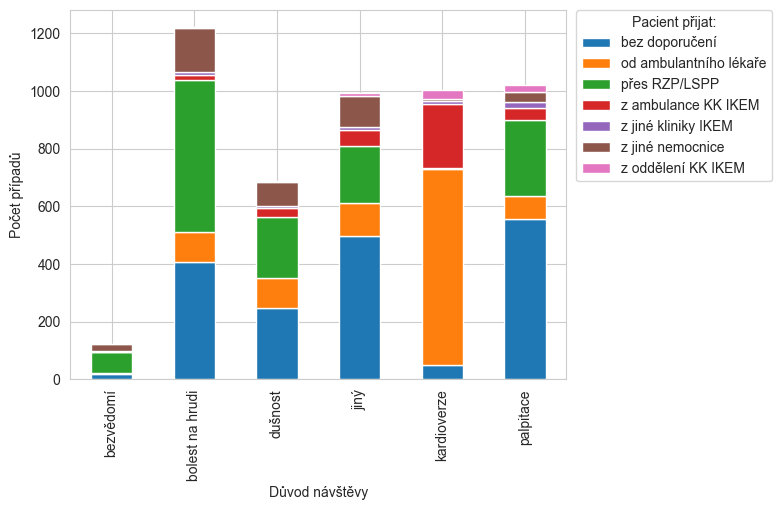

In [20]:
cases_df = patients_df.groupby('cause')['accepted'].value_counts(
    normalize=False).unstack('accepted')

ax = cases_df.plot.bar(stacked=True)
ax.set(xlabel='Důvod návštěvy', ylabel='Počet případů')
plt.legend(title='Pacient přijat:', bbox_to_anchor=(
    1.02, 1), loc='upper left', borderaxespad=0)
